# Building a Roller Coaster Dataset from Wikipedia

![test](https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fwww.travelandleisure.com%2Fsites%2Fdefault%2Ffiles%2Fstyles%2F1600x1000%2Fpublic%2F1475074126%2Frollercoaster-KIDNEY0916.jpg%3Fitok%3DbpPex-qD&f=1&nofb=1)

In this notebook I'll attempt to gather data about roller coasters!

This code was created during a live stream on twitch. Check out my channel here: https://www.twitch.tv/medallionstallion_

In [1]:
!pip install Wikipedia-API > /dev/null

In [2]:
import pandas as pd
import numpy as np
import wikipediaapi
from tqdm.notebook import tqdm

pd.set_option('max_columns', 500)

In [3]:
def parse_coaster_infobox(url, coaster_name, filter_cols=False):
    """
    Takes a coaster wikipedia url.
    Pulls info from the infobox and returns as a dataframe
    """
    try:
        df = pd.read_html(url, attrs= {'class': 'infobox'})[0]
    except ValueError:
        return pd.DataFrame()

    mycoaster = df.columns[0]
    df = df[df.columns[:2]]
    df.columns = ['Coaster', 'Value']
    df = df.set_index('Coaster')
    df = df.loc[~df.index.isna()]
    if filter_cols:
        MAIN_KEYS = ['coaster_name', 'Length', 'Speed', 'Location', 'Coordinates',
                     'Status', 'Opening date',
                     'General statistics', 'Type', 'Manufacturer',
                     'Height restriction',
                     'Model', 'Height', 'Inversions', 'Lift/launch system',
                     'Cost', 'Trains',
                     'Park section', 'Duration', 'Capacity',
                     'G-force', 'Designer',
                     'Max vertical angle', 'Drop', 'Soft opening date',
                     'Fast Lane available', 'Replaced', 'Track layout',
                     'Fastrack available', 'Soft opening date',
                     'Closing date', 'Opened', 'Replaced by', 'General Statistics',
                     'Website', 'Flash Pass Available', 'Must transfer from wheelchair',
                     'Theme', 'Single rider line available',
                     'Restraint Style', 'Flash Pass available', 'Acceleration',
                      'Restraints', 'Name']

        FILTERED_KEYS = [v for v in df.index if v in MAIN_KEYS]
        df = df.loc[FILTERED_KEYS]
    df = df.T
    df.index = [mycoaster]
    df = dedup_infobox(df)
    df['coaster_name'] = coaster_name
    return df

def dedup_infobox(df):
    dup_cols = df.columns[df.columns.duplicated()].unique()
    for c in dup_cols:
        cols = []
        count = 1
        for column in df.columns:
            if column == c:
                cols.append(f'{c}_{count}')
                count+=1
                continue
            cols.append(column)
        df.columns = cols
    return df

# Gathering from Wikipedia
- Category:Operating roller coasters

What are we going to do here?
1. Get a list of all the roller coasters from the category.
2. Iterate over each and load the page using the wiki api
3. Pull key statistics and gather into a dataset
Features:
    - Location
    - Coords
    - Height
    - Construction (Wood / Steel)
    - Dates
        - Opening date
        - Closing date
    - Cost
    - Speed

## We have 692 Operating Coasters

In [4]:
wiki = wikipediaapi.Wikipedia('en')
cat = wiki.page('Category:Operating roller coasters')
len(cat.categorymembers)

ds = []
for coaster, page in tqdm(cat.categorymembers.items()):
    url = page.fullurl
    ds.append(parse_coaster_infobox(url,coaster, filter_cols=True))
coaster_db = pd.concat(ds)

  0%|          | 0/687 [00:00<?, ?it/s]

In [5]:
#ds

In [6]:
coaster_db = pd.concat(ds)

In [7]:
coaster_db.head

<bound method NDFrame.head of                                                         Location  \
10 Inversion Roller Coaster                   Chimelong Paradise   
Abyss                                            Adventure World   
Abyssus                                             Energylandia   
Accelerator                                 Drayton Manor Resort   
Acrobat                                       Nagashima Spa Land   
...                                                          ...   
Switchback                                  ZDT's Amusement Park   
Zeus                              Mt. Olympus Water & Theme Park   
(Zimerman, Gloria's Fantasyland)                             NaN   
Zippin Pippin                                                NaN   
Zoomerang                                         Lake Compounce   

                                    Park section  \
10 Inversion Roller Coaster       Screaming Zone   
Abyss                                        NaN 

# TODO
- Go through entire list of coasters from wikipedia category
    - https://en.wikipedia.org/wiki/Category:Roller_coaster_introductions_by_year
- Parse data:
    - years/dates
    - Capacity
    - Coordinates

In [8]:
# Save off our results
coaster_db.to_csv('coaster_db.csv', index_label='Coaster')
coaster_db = pd.read_csv('coaster_db.csv')

In [9]:
coaster_db.head

<bound method NDFrame.head of                                   Coaster                        Location  \
0             10 Inversion Roller Coaster              Chimelong Paradise   
1                                   Abyss                 Adventure World   
2                                 Abyssus                    Energylandia   
3                             Accelerator            Drayton Manor Resort   
4                                 Acrobat              Nagashima Spa Land   
..                                    ...                             ...   
682                            Switchback            ZDT's Amusement Park   
683                                  Zeus  Mt. Olympus Water & Theme Park   
684  ('Zimerman', "Gloria's Fantasyland")                             NaN   
685                         Zippin Pippin                             NaN   
686                             Zoomerang                  Lake Compounce   

       Park section                          

In [17]:
list(coaster_db['Coordinates'])[0]

'.mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}23°00′16″N 113°19′37″E\ufeff / \ufeff23.004355°N 113.326913°ECoordinates: 23°00′16″N 113°19′37″E\ufeff / \ufeff23.004355°N 113.326913°E'

# Parse Coords

In [18]:
def parse_coordinates(df):
    """
    Messy clean of coordinates - fix and make better later
    """
    coaster_db['Coordinates'] = coaster_db['Coordinates'].str.split('/').str[-1]
    coaster_db['lat_str'] = coaster_db['Coordinates'].str.split(' ').str[1]
    coaster_db['lon_str'] = coaster_db['Coordinates'].str.split(' ').str[2]

    coaster_db['lat'] = coaster_db['lat_str'].str[:-2].str.strip('\ufeff').astype('float')
    coaster_db['lon'] = coaster_db['lon_str'].str[:-2].str.strip('\ufeff').str.strip('°E[').str.strip('°W').astype('float')

    return df

coaster_db = parse_coordinates(coaster_db)

In [19]:
coaster_db.head()

,Coaster,Location,Park section,Coordinates,Status,Opening date,General statistics,Type,Manufacturer,Designer,Model,Track layout,Lift/launch system,Height,Length,Speed,Inversions,Duration,Capacity,Height restriction,Trains,coaster_name,Cost,Drop,Max vertical angle,G-force,Soft opening date,Website,Replaced,Fast Lane available,Coordinates_1,Coordinates_2,Coordinates_3,Status_1,Status_2,Status_3,Opening date_1,Opening date_2,Opening date_3,Coordinates_4,Coordinates_5,Coordinates_6,Status_4,Status_5,Status_6,Opening date_4,Opening date_5,Opening date_6,Closing date_1,Closing date_2,Replaced by_1,Replaced by_2,Coordinates_7,Coordinates_8,Coordinates_9,Status_7,Status_8,Status_9,Opening date_7,Opening date_8,Opening date_9,Closing date_3,Closing date_4,Replaced by_3,Replaced by_4,General Statistics,Must transfer from wheelchair,Flash Pass Available,Flash Pass available,Single rider line available,Name,Closing date,Cost_1,Cost_2,Cost_3,Cost_4,Park section_1,Park section_2,Park section_3,Park section_4,Park section_5,Park section_6,Replaced_1,Replaced_2,Park section_7,Park section_8,Park section_9,Replaced_3,Replaced_4,Acceleration,Theme,Park section_10,Park section_11,Park section_12,Coordinates_10,Coordinates_11,Coordinates_12,Status_10,Status_11,Status_12,Opening date_10,Opening date_11,Opening date_12,Park section_13,Park section_14,Park section_15,Park section_16,Coordinates_13,Coordinates_14,Coordinates_15,Coordinates_16,Status_13,Status_14,Status_15,Status_16,Opening date_13,Opening date_14,Opening date_15,Opening date_16,Restraints,Name_1,Name_2,Name_3,Name_4,Replaced by,Fastrack available,Soft opening date_1,Soft opening date_2,Soft opening date_3,Soft opening date_4,Location_1,Location_2,Location_3,Location_4,Restraint Style,Closing date_5,Closing date_6,Closing date_7,Closing date_8,Coordinates_17,Coordinates_18,Coordinates_19,Coordinates_20,Status_17,Status_18,Status_19,Status_20,Opening date_17,Opening date_18,Opening date_19,Opening date_20,Closing date_9,Closing date_10,Closing date_11,Closing date_12,Coordinates_21,Coordinates_22,Coordinates_23,Coordinates_24,Coordinates_25,Status_21,Status_22,Status_23,Status_24,Status_25,Opening date_21,Opening date_22,Opening date_23,Opening date_24,Opening date_25,Closing date_13,Closing date_14,Closing date_15,Closing date_16,Coordinates_26,Coordinates_27,Coordinates_28,Coordinates_29,Coordinates_30,Status_26,Status_27,Status_28,Status_29,Status_30,Opening date_26,Opening date_27,Opening date_28,Opening date_29,Opening date_30,Closing date_17,Closing date_18,Closing date_19,Closing date_20,Coordinates_31,Coordinates_32,Coordinates_33,Coordinates_34,Coordinates_35,Coordinates_36,Status_31,Status_32,Status_33,Status_34,Status_35,Status_36,Opening date_31,Opening date_32,Opening date_33,Opening date_34,Opening date_35,Opening date_36,Closing date_21,Closing date_22,Closing date_23,Closing date_24,Closing date_25,Park section_17,Park section_18,Park section_19,Park section_20,Park section_21,Park section_22,Park section_23,Park section_24,Park section_25,Park section_26,Park section_27,Park section_28,Park section_29,Park section_30,Park section_31,Park section_32,Park section_33,Park section_34,Park section_35,Park section_36,Replaced by_5,Replaced by_6,Replaced by_7,Replaced by_8,Replaced by_9,Cost_5,Cost_6,Cost_7,Cost_8,Cost_9,Website_1,Website_2,Website_3,Website_4,lat_str,lon_str,lat,lon
0,10 Inversion Roller Coaster,Chimelong Paradise,Screaming Zone,﻿23.004355°N 113.326913°E,Operating,2006,General statistics,Steel,Intamin,Werner Stengel,Multi Inversion Coaster,10 Inversion Revision A,Chain lift hill,98.4 ft (30.0 m),"2,788.8 ft (850.0 m)",45 mph (72 km/h),10,1:32,"1,340 riders per hour",54–77 in (137–196 cm),Single train with 7 cars. Riders are arranged ...,10 Inversion Roller Coaster,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

# Trying to plot all the coaster on a map
- TODO - fix this later!

In [20]:
import plotly.express as px
import pandas as pd

fig = px.scatter_geo(coaster_db,lat='lat',lon='lon')
fig.update_layout(title = 'Coaster map', title_x=0.5)
fig.show()

In [21]:
DEBUG = False
wiki = wikipediaapi.Wikipedia('en')
cat = wiki.page('Category:Roller_coaster_introductions_by_year')
i = 0
ds = []
for year in tqdm(cat.categorymembers):
    cat_year = wiki.page(year)
    cat_year.categorymembers
    for coaster, page in cat_year.categorymembers.items():
        url = page.fullurl
        parsed_df = parse_coaster_infobox(url, coaster, filter_cols=True)
        parsed_df['year_introduced'] = int(year[-4:])
        ds.append(parsed_df)
        i += 1
    if i == 20 and DEBUG:
        break
if not DEBUG:
    coaster_db = pd.concat(ds)

  0%|          | 0/105 [00:00<?, ?it/s]

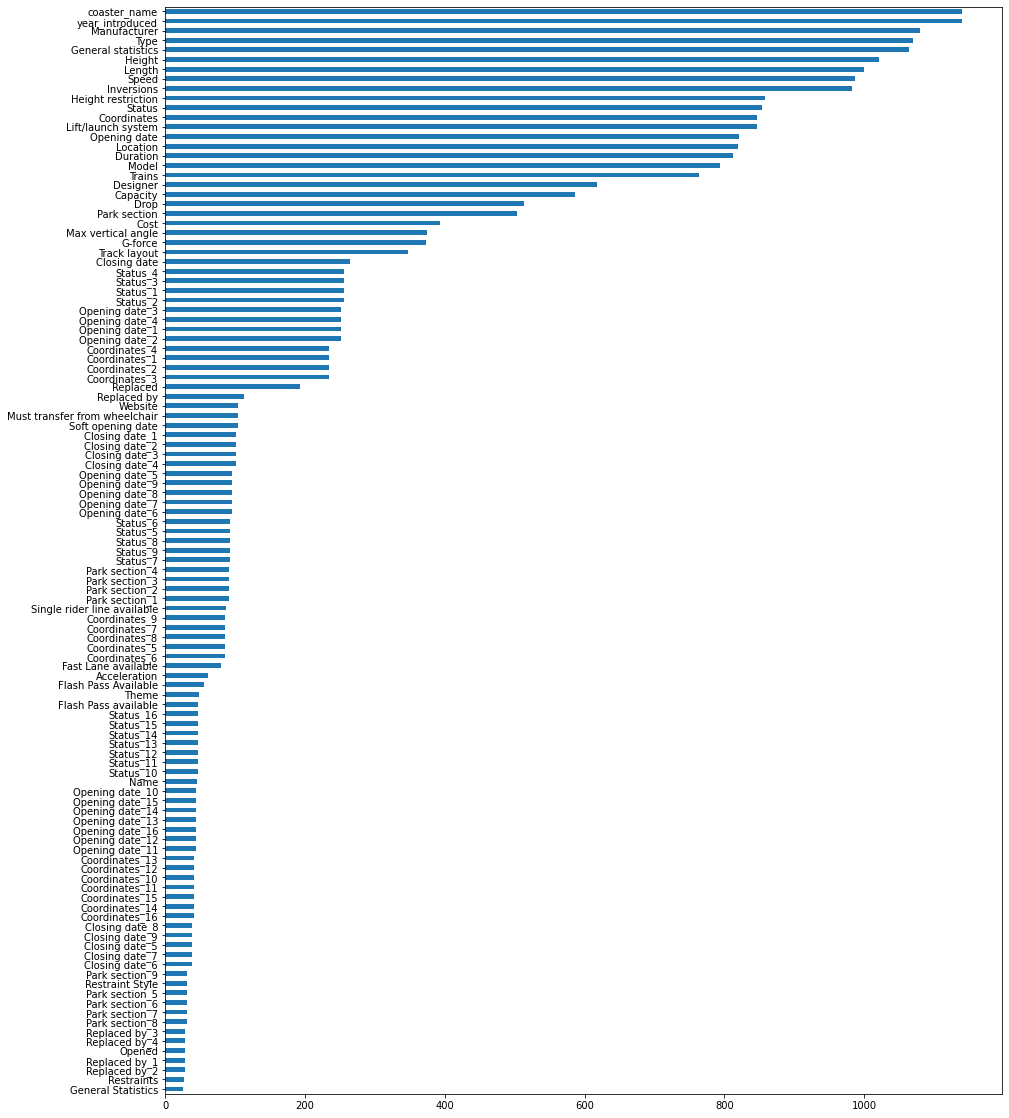

In [22]:
(~coaster_db.isna()).sum().to_frame().rename(columns={0:'count'}) \
    .query('count > 20') \
    ['count'].sort_values(ascending=True) \
    .plot(kind='barh',
          figsize=(15, 20)
         )

In [23]:
MAIN_KEYS = ['coaster_name', 'Length', 'Speed', 'Location', 'Coordinates',
                     'Status', 'Opening date',
                     'General statistics', 'Type', 'Manufacturer',
                     'Height restriction',
                     'Model', 'Height', 'Inversions', 'Lift/launch system',
                     'Cost', 'Trains',
                     'Park section', 'Duration', 'Capacity',
                     'G-force', 'Designer',
                     'Max vertical angle', 'Drop', 'Soft opening date',
                     'Fast Lane available', 'Replaced', 'Track layout',
                     'Fastrack available','Soft opening date',
                     'Closing date', 'Opened', 'Replaced by', 'General Statistics',
                     'Website', 'Flash Pass Available', 'Must transfer from wheelchair',
                     'Theme', 'Single rider line available',
                     'Restraint Style',
                      'Flash Pass available', 'Acceleration',
                      'Restraints', 'Name','year_introduced']


In [24]:
coaster_db[MAIN_KEYS].to_csv('coaster_db_v2.csv')

In [28]:
coaster_db=pd.read_csv('coaster_db_v2.csv')
coaster_db.shape

(1140, 46)